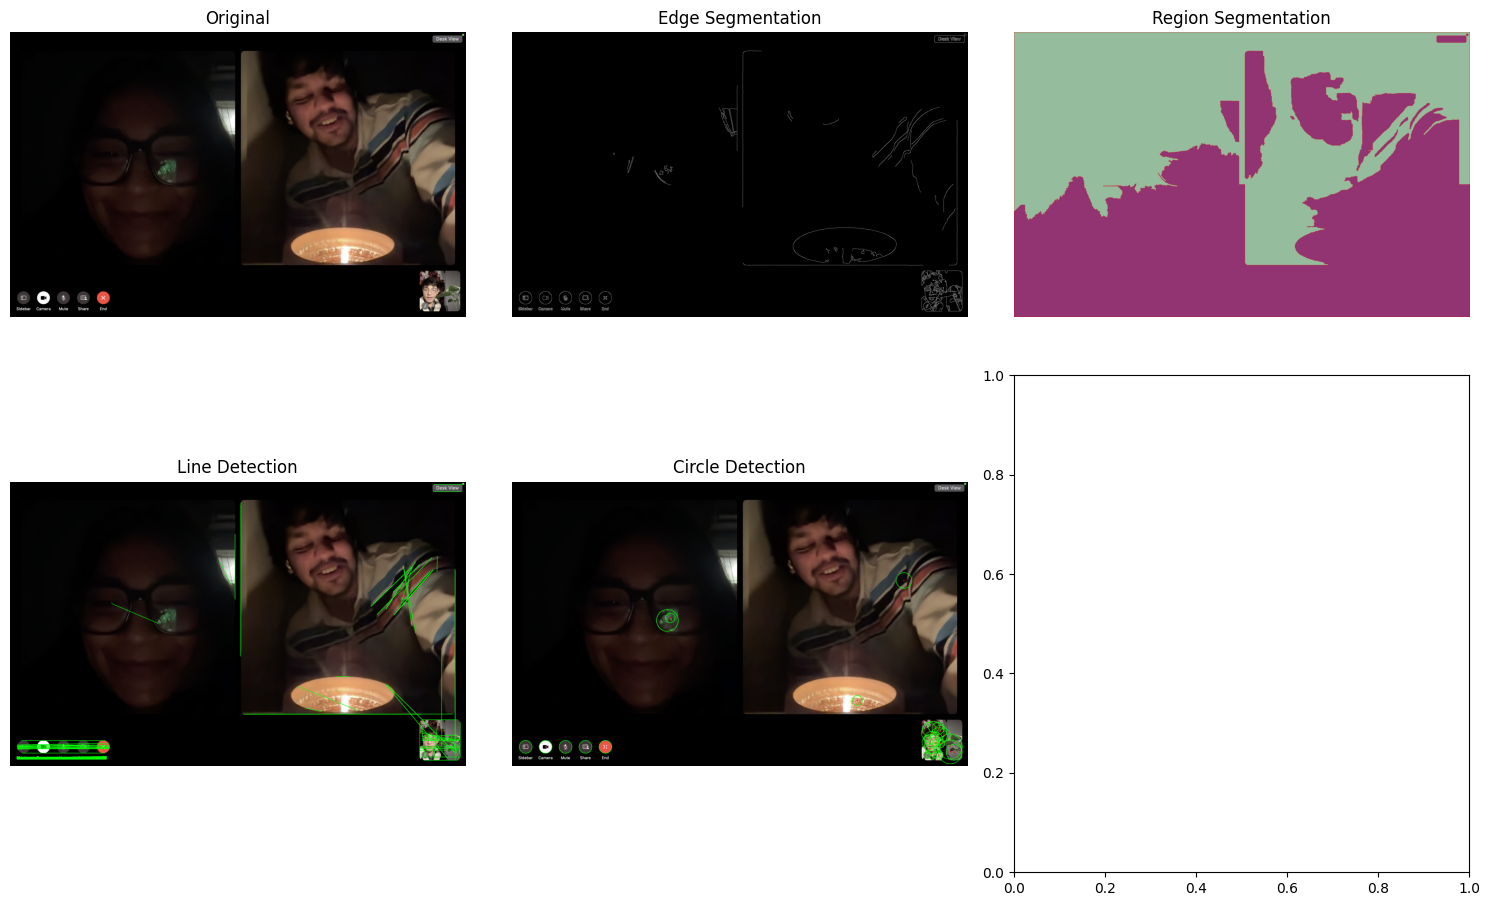

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_images(images, titles, rows=1, figsize=(15, 10)):
    """Helper function to display multiple images with titles"""
    cols = len(images) // rows + (1 if len(images) % rows != 0 else 0)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:  # Grayscale image
            axes[i].imshow(img, cmap='gray')
        else:  # Color image
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# T1.1: Edge-based Segmentation using Canny
def edge_segmentation(image):
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    return edges

# T1.2: Region-based Segmentation using watershed algorithm
def region_segmentation(image):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Threshold the image
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the unknown region with 0
    markers[unknown == 255] = 0

    # Apply watershed algorithm
    markers = cv2.watershed(image.copy(), markers)

    # Create a color visualization of segmentation
    segmented = np.zeros_like(image)
    if len(image.shape) == 3:  # Color image
        for i in range(1, markers.max() + 1):
            # Random color for each segment
            segmented[markers == i] = [np.random.randint(0, 255),
                                      np.random.randint(0, 255),
                                      np.random.randint(0, 255)]
    else:  # Grayscale image
        for i in range(1, markers.max() + 1):
            segmented[markers == i] = np.random.randint(50, 200)

    # Mark boundaries in red
    segmented[markers == -1] = [0, 0, 255] if len(image.shape) == 3 else 255

    return segmented

# T1.3: Hough Transform for line and circle detection
def hough_line_detection(image, edges=None):
    # Create a copy to draw lines on
    line_image = image.copy()

    # If edges not provided, generate them
    if edges is None:
        edges = edge_segmentation(image)

    # Apply probabilistic Hough Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)

    # Draw detected lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return line_image

def hough_circle_detection(image):
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,  # Resolution ratio
        minDist=20,  # Minimum distance between circles
        param1=50,  # Upper threshold for Canny edge detector
        param2=30,  # Threshold for center detection
        minRadius=10,
        maxRadius=100
    )

    # Create a copy to draw circles on
    circle_image = image.copy()

    # Draw detected circles on the image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(circle_image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(circle_image, (i[0], i[1]), 2, (0, 0, 255), 3)

    return circle_image

# Main function to execute all tasks
def task1_main(image_path):
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    # T1.1: Edge-based segmentation
    edges = edge_segmentation(image)

    # T1.2: Region-based segmentation
    region_segmented = region_segmentation(image)

    # T1.3: Hough transform for line detection
    line_detected = hough_line_detection(image, edges)

    # T1.3: Hough transform for circle detection
    circle_detected = hough_circle_detection(image)

    # Display all results
    display_images(
        [image, edges, region_segmented, line_detected, circle_detected],
        ['Original', 'Edge Segmentation', 'Region Segmentation', 'Line Detection', 'Circle Detection'],
        rows=2
    )

# Example usage
if __name__ == "__main__":
    # Replace with your road image path
    image_path = "/content/Screenshot 2024-12-14 at 1.10.08 AM.png"
    task1_main(image_path)

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist, cifar100
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Helper function to display images
def display_results(images, titles, figsize=(15, 10)):
    """Display multiple images with titles"""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]

    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:  # Grayscale image
            axes[i].imshow(img, cmap='gray')
        else:  # Color image with BGR format (OpenCV)
            if img.dtype == np.uint8:
                axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                axes[i].imshow(img)  # Assume it's already in RGB
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# T2.1: YOLO Object Detection
def yolo_detection(image_path):
    """
    Perform object detection using YOLO model
    """
    # Load the model
    model = YOLO('yolov8n.pt')  # Using YOLOv8 nano model for faster inference

    # Perform prediction
    results = model(image_path)

    # Load the image for visualization
    image = cv2.imread(image_path)

    # Visualize results
    result_image = results[0].plot()

    return result_image

# T2.2: Simple R-CNN-like implementation
def rcnn_detection(image_path, threshold=0.8):
    """
    Simplified R-CNN implementation using selective search and VGG16
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Create selective search segmentation object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # Set input image
    ss.setBaseImage(image)

    # Use selective search fast mode
    ss.switchToSelectiveSearchFast()

    # Process to get region proposals
    rects = ss.process()

    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=True)

    # Create a copy of image for visualization
    output = image.copy()

    # Limit number of proposals for efficiency
    max_proposals = 50
    processed_rects = min(len(rects), max_proposals)

    # Process each region proposal
    for i, rect in enumerate(rects[:processed_rects]):
        x, y, w, h = rect

        # Ensure the region is within image boundaries
        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue

        # Extract the region
        region = image[y:y+h, x:x+w]

        # Resize to VGG16 input size
        try:
            resized = cv2.resize(region, (224, 224))
        except cv2.error:
            continue

        # Preprocess for VGG16
        input_data = np.expand_dims(resized, axis=0)
        input_data = tf.keras.applications.vgg16.preprocess_input(input_data)

        # Get prediction
        predictions = base_model.predict(input_data, verbose=0)

        # Get top prediction
        predicted_class = np.argmax(predictions)
        score = predictions[0, predicted_class]

        # If prediction confidence is high, draw the bounding box
        if score > threshold:
            # Get the class name from ImageNet labels (simplified version)
            class_name = f"Class {predicted_class}"

            # Draw rectangle and label
            cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(output, class_name, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return output

# Additional task: Working with Fashion MNIST dataset
def fashion_mnist_demo():
    """
    Load and display samples from Fashion MNIST dataset
    """
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Class names for Fashion MNIST
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Display some examples
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap='gray')
        plt.xlabel(class_names[y_train[i]])
    plt.tight_layout()
    plt.show()

    # Train a simple CNN model
    model = train_fashion_mnist_model(x_train, y_train, x_test, y_test)

    # Perform object detection on a test image
    test_idx = np.random.randint(0, len(x_test))
    test_image = x_test[test_idx]
    test_label = class_names[y_test[test_idx]]

    # Make prediction
    predictions = model.predict(np.expand_dims(test_image, axis=0))
    predicted_class = np.argmax(predictions)

    # Display result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title(f"True: {test_label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_image, cmap='gray')
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def train_fashion_mnist_model(x_train, y_train, x_test, y_test):
    """Train a simple CNN model for Fashion MNIST classification"""
    # Preprocess data
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Reshape for CNN input (add channel dimension)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    # One-hot encode labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Create a simple model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model (with a small number of epochs for demonstration)
    model.fit(x_train, y_train, epochs=3, batch_size=64,
              validation_data=(x_test, y_test), verbose=1)

    return model

# Additional task: Working with CIFAR-100 dataset
def cifar100_demo():
    """
    Load and display samples from CIFAR-100 dataset
    """
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Define class names (simplified version)
    fine_labels = [f"Class {i}" for i in range(100)]

    # Display some examples
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i])
        plt.xlabel(fine_labels[y_train[i][0]])
    plt.tight_layout()
    plt.show()

# Main function to execute Task 2
def task2_main(image_path):
    # T2.1: YOLO Object Detection
    yolo_result = yolo_detection(image_path)

    # T2.2: Simple R-CNN-like implementation
    rcnn_result = rcnn_detection(image_path)

    # Display results
    if rcnn_result is not None:
        display_results(
            [yolo_result, rcnn_result],
            ['YOLO Detection', 'R-CNN-like Detection'],
            figsize=(15, 7)
        )
    else:
        display_results(
            [yolo_result],
            ['YOLO Detection'],
            figsize=(8, 7)
        )

    # Optional: Uncomment to run Fashion MNIST and CIFAR-100 demos
    # print("Demonstrating Fashion MNIST...")
    # fashion_mnist_demo()
    #
    # print("Demonstrating CIFAR-100...")
    # cifar100_demo()

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/Screenshot 2024-12-14 at 1.10.08 AM.png"
    task2_main(image_path)


image 1/1 /content/Screenshot 2024-12-14 at 1.10.08 AM.png: 416x640 3 persons, 48.8ms
Speed: 14.2ms preprocess, 48.8ms inference, 354.4ms postprocess per image at shape (1, 3, 416, 640)
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-1-a6b575507b45>", line 269, in <cell line: 0>

  File "<ipython-input-1-a6b575507b45>", line 242, in task2_main

  File "<ipython-input-1-a6b575507b45>", line 109, in rcnn_detection

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_666]